In [2]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision  # Add this import
from torchvision import transforms
from torch.autograd import Function
import torch.nn.functional as F

In [3]:
# Define Grad-CAM class (as defined earlier)
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hook for gradients
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        # Hook for forward activations
        def forward_hook(module, input, output):
            self.activations = output

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate_cam(self, input_tensor, target_class=None):
        self.model.eval()

        # Forward pass to get outputs
        output = self.model(input_tensor)
        if target_class is None:
            target_class = torch.argmax(output)

        # Backpropagate gradients for the target class
        self.model.zero_grad()
        output[:, target_class].backward()

        # Compute the Grad-CAM
        gradients = self.gradients.detach().cpu().numpy()  # Detach gradients before converting
        activations = self.activations.detach().cpu().numpy()  # Detach activations before converting
        weights = np.mean(gradients, axis=(2, 3))  # Global average pooling
        cam = np.zeros(activations.shape[2:], dtype=np.float32)
        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize
        return cam

In [4]:
# Preprocessing function (same as before)
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return image_tensor

In [5]:
# Load the model architecture and weights
def load_model(model_path):
    # Define the model architecture here
    model = torchvision.models.vgg16(pretrained=False)  # Example: VGG16
    model.classifier[6] = nn.Linear(in_features=4096, out_features=2)  # Adjust the last layer for binary classification

    # Load the saved model weights
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()  # Set model to evaluation mode
    return model

In [6]:
# Function to predict and generate heatmap (same as before)
def predict_and_generate_heatmap(model, image_path, target_layer):
    input_tensor = preprocess_image(image_path).to(device)
    
    # Initialize Grad-CAM
    gradcam = GradCAM(model=model, target_layer=target_layer)

    # Generate the heatmap
    cam = gradcam.generate_cam(input_tensor)

    # Make prediction
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        predicted_label = "Infected" if predicted.item() == 1 else "Uninfected"

    # Visualize the heatmap
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(image, 0.5, heatmap, 0.5, 0)

    # Plot the results
    plt.figure(figsize=(10, 5))
    
    # Show original image with prediction label
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image\nPredicted: {predicted_label}")
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Show Grad-CAM heatmap with prediction label
    plt.subplot(1, 2, 2)
    plt.title(f"Grad-CAM Heatmap\nPredicted: {predicted_label}")
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    
    plt.show()

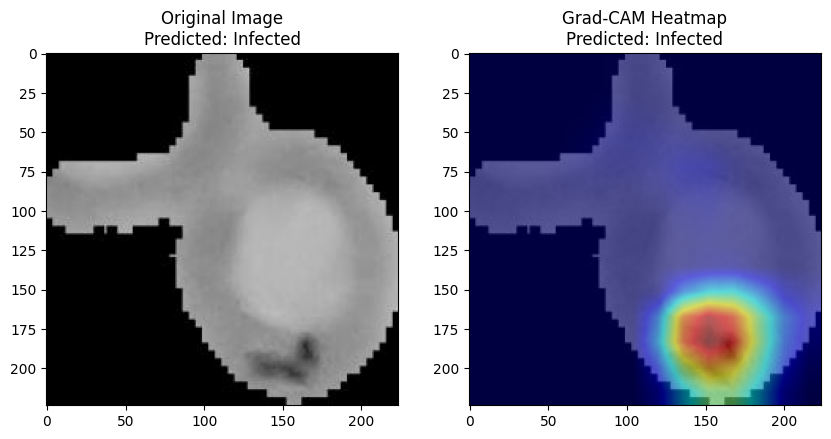

In [14]:
# Main execution
if __name__ == "__main__":
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load the model (make sure the path is correct)
    model_path = "cancer_model_full_dataset.pth"  # Path to your saved model
    model = load_model(model_path).to(device)

    # Example usage
    image_path = "Demo/Inf/b.jpg"  # Path to the image you want to classify
    target_layer = model.features[29]  # Set the target layer for Grad-CAM
    predict_and_generate_heatmap(model, image_path, target_layer)